## 第三部分 二维码识别

第二部分中，已经从车票中已经截取出了较为端正且占据图片最主要部分的二维码图片。但是直接使用zbar库识别只能识别出38张，效果很不理想。因此采用一些方法进行增强。

观察未能识别出的二维码，可以观察到它们有明显的几处共同点：
* 背景与前景相差较小
* 二维码中部分像素较模糊
* 二维码附近有少量污染
* 二维码三个定位块比例不一致
* ……

为了解决以上主要问题，主要采取的方法有：
* 二维码增强
* 二维码变形

最终运用算法，在训练集上一共识别出79/100张火车票二维码。

In [14]:
# temp import
import os
import cv2
import numpy as np
from tqdm import tqdm
from pyzbar import pyzbar
import matplotlib.pyplot as plt

### 二维码增强
此处用一张无法直接扫出的图：```0002.bmp```为例说明二维码的增强算法，包括这张图在内的18张图最终通过增强算法识别出来：

result: []


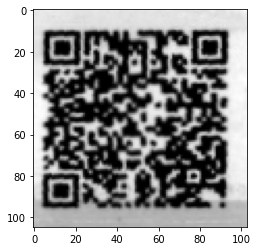

In [2]:
img2 = cv2.imread('qr/0002.bmp', cv2.IMREAD_GRAYSCALE)

print('result:',pyzbar.decode(img2)) # no result
plt.imshow(img2, cmap='gray')

#### 顶帽变换

对于这张图片，即便是微信的强大二维码识别器也没能通过拍照扫描出来，但是如果直接讲这张图保存为文件并使用微信扫描，其用了**明显比扫描一般二维码更长的时间**扫描出了二维码的内容。

这张图片的特点是：内部像素分界线较模糊，且下方背景在颜色上有所区别。

为了避免背景上的差异，这里使用了顶帽变换：$T_{hat}(f)=f-(f\circ b)$.

但需要注意，顶帽变换是删除暗背景上的亮物体后，再被原图像所进去达到消除背景的目的。这里更加白而亮的是背景，而较暗较黑的二维码才是目标，因此需要在顶帽变换的前后将图像取反，顶帽变换后的结果如下图所示：

result: []


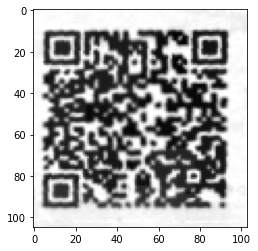

In [3]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))

img = 255 - img2
morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
output = 255 - cv2.subtract(img, morphed)

print('result:',pyzbar.decode(output)) # no result
plt.imshow(output, cmap='gray')

#### 高通滤波
可以看到，顶帽变化后背景色的差异被明显消除，且背景更加白，与二维码本身的差异更加，直观上图像的对比度增强。与原先的图片相比顶帽变换取得了很好的效果。即便如此，pyzbar依然未能将这张图识别出来，从图像看推测是因为部分像素有些模糊，为此考虑增加一个高通滤波。

经过一番尝试（见最后），最终依然选取了最简单的拉普拉斯算子作增强，增强后的图片如下：

result []


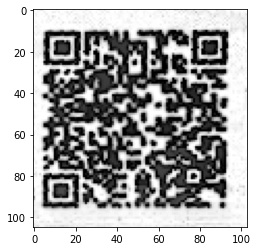

In [4]:
laplacian = cv2.Laplacian(output, -1)
new_img =cv2.subtract(output, laplacian).astype(np.uint8)
print('result', pyzbar.decode(new_img))
plt.imshow(new_img, cmap='gray')

#### 二值化（自适应&全局）
经过拉普拉斯增强后，二维码中各像素的轮廓变得清晰，而且此时微信在拍照模式识别二维码时，也可以将其识别出来。这说明尽管目前pyzbar依然未能识别出二维码，先前的方法已经使得二维码更加容易识别。但目前为止库未能识别出二维码，推测是较多的灰度种类对识别造成的一定的影响，因此将其二值化。

尽管顶帽变换已经将背景清理得较为干净，但仍然不能保证顶帽变换一定可以取得完美的结果，因此使用局部的二值化是有必要的。这里首先使用一种局部二值化方法——自适应二值化。

result: [Decoded(data=b'200087091412511530034667018715167684507415962791635763805933362167467427339290781150856974557013246690526991430482730086132393961481603217718497', type='QRCODE', rect=Rect(left=5, top=10, width=87, height=85), polygon=[Point(x=5, y=95), Point(x=92, y=95), Point(x=92, y=10), Point(x=6, y=10)])]


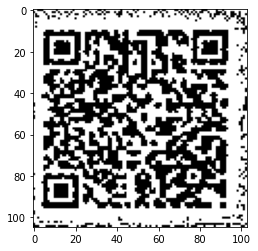

In [5]:
test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
print('result:', pyzbar.decode(test))
plt.imshow(test, cmap='gray')

#### 汇总
自适应二值化后，得到的二维码已经能被成功识别出来。为了避免自适应滤波失败的情况，如果自适应滤波失败将在之后枚举二值化的threshold，尝试识别，知道扫出或全部枚举完成为止。将以上操作合并，即构成二维码的增强过程，下图显示各过程中图像的变化：

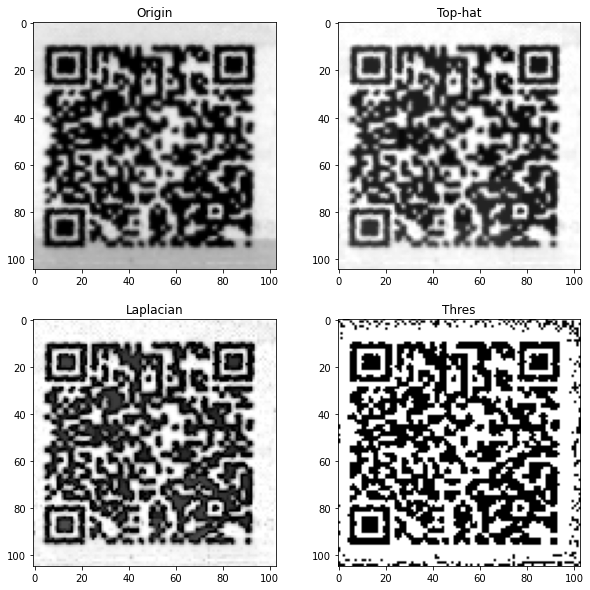

In [6]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Origin')
plt.imshow(img2, cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Top-hat')
plt.imshow(output, cmap='gray')
plt.subplot(2, 2, 3)
plt.title('Laplacian')
plt.imshow(new_img, cmap='gray')
plt.subplot(2, 2, 4)
plt.title('Thres')
plt.imshow(test, cmap='gray')

以下是二维码增强过程的代码，即汇总后的操作：

In [7]:
def recog_qr(img, not_continue=False):
    barcodes=pyzbar.decode(img)
    if len(barcodes) > 0:
        return 0, barcodes[0].data.decode('utf-8')
    
    img = 255 - img
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    output = 255 - cv2.subtract(img, morphed)
    barcodes=pyzbar.decode(output)
    if len(barcodes) > 0:
        return 1, barcodes[0].data.decode('utf-8')

    laplacian = cv2.Laplacian(output, -1)
    new_img =cv2.subtract(output, laplacian)
    barcodes=pyzbar.decode(new_img)
    if len(barcodes) > 0:
        return 2, barcodes[0].data.decode('utf-8')
    
    test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    barcodes=pyzbar.decode(test)
    if len(barcodes) > 0:
        return 3, barcodes[0].data.decode('utf-8')
    test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
    barcodes=pyzbar.decode(test)
    if len(barcodes) > 0:
        return 3, barcodes[0].data.decode('utf-8')
    
    if not_continue:
        return -1, ''

    for i in range(127, 256):  #粗暴的阈值处理
        _, output2 = cv2.threshold(new_img, i, 255, cv2.THRESH_BINARY)
        barcodes=pyzbar.decode(output2)
        if len(barcodes) != 0:
            return 4, barcodes[0].data.decode('utf-8')
    return -1, ''

直接利用此增强函数，可额外识别出18张二维码，最终的统计结果表明，其中的每一步都使得额外识别出的二维码增多。具体可见稍后的完整统计数据。可以在下方修改图片文件名观察结果：

result: (3, '160573880588446653888586080716060867939114590463043555344813116325236144205644088570421821162053177899242722637700191793898215102901936272194193')


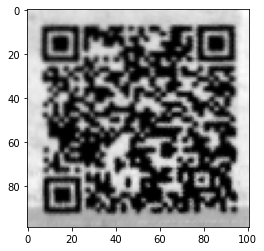

In [8]:
img = cv2.imread('qr/0009.bmp', cv2.IMREAD_GRAYSCALE)
print('result:', recog_qr(img))
plt.imshow(img, cmap='gray')

### 二维码变形
在做完以上操作后，分析未识别出的二维码，发现其中有一大部分二维码，它们的三个定位块左侧和右侧的大小不一，而即便是（看上去）清晰的二维码，使用微信等很成熟的二维码识别软件也未能识别出，下图的两个图片即是典型的对比，其中左侧二维码可以识别，但右侧的二维码无法识别：

left:	 (0, '020857431064020019372589033206091774738561342081499839159125585322699570616599910102789788168182714050628291939914057657074397649366418084317787')
right:	 (-1, '')


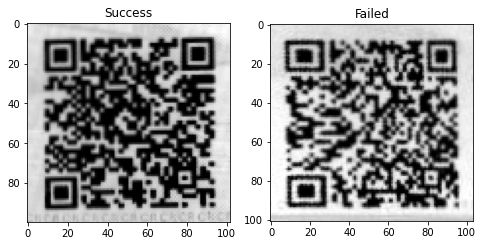

In [9]:
img = cv2.imread('qr/0004.bmp', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('qr/0003.bmp', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Success')
plt.imshow(img2, cmap='gray')
print('left:\t', recog_qr(img2))

plt.subplot(1, 2, 2)
plt.title('Failed')
plt.imshow(img, cmap='gray')
print('right:\t', recog_qr(img))

上方右图中，很明显地观察到左侧两个定位块并行比右侧的定位块要“胖”，有可能是自动打印车票时车票移动速度不均匀导致的。因此考虑如下简易模型：二维码水平线```divide```（比例）处往左，图像需要在水平方向缩放```rate```倍后，使得左边部分不协调的比例相对于右边更加正常，假设$divide=0.4,~rate=0.8$，纠正出的如下代码所示：


result	 (0, '030755010316505862241125261889992389638269950028739393303410107418124646925447071471998936107042924718513843814341408380917162804569442148109605')


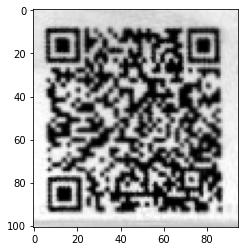

In [10]:
r, c = img.shape
rate = 0.8
divide = 0.4

crop_x = int(c * divide)
left_img = img[:, :crop_x]
right_img = img[:, crop_x:]

rl, cl = left_img.shape
left_img2 = cv2.resize(left_img, (int(cl*rate),  rl))
fit_img = np.hstack([left_img2, right_img])
print('result\t', recog_qr(fit_img))
plt.imshow(fit_img, cmap='gray')

原来的图经过这种部分缩放的处理后，由原本的不可识别变为可识别。由于数据集中这样图由很多，因此可采用的方法是：先尝试直接调用二维码增强函数识别，如果无法识别，则尝试在合理的区间与步长内枚举上述```divide```与```rate```，再次尝试识别，直到识别出为止。另外考虑到效率问题，在枚举变换参数时二维码增强不再进行最后一步枚举二值化阈值，根据实验其性能极其有限而且耗时巨大。

In [11]:
def process_qr(img):
    status, content = recog_qr(img, False)
    if status != -1:
        return status, content
    
    for rate in np.arange(0.8, 1, 0.01):
        for divide in np.arange(0.25, 0.5, 0.05):
            r, c = img.shape
            crop_x = int(c * divide)
            left_img = img[:, :crop_x]
            right_img = img[:, crop_x:]
            rl, cl = left_img.shape
            left_img2 = cv2.resize(left_img, (int(cl*rate),  rl))
            fit_img = np.hstack([left_img2, right_img])

            status, content = recog_qr(fit_img, True)
            if status != -1:
                return status, content
    return -1, ''

将以上操作汇总，即得到最终的处理函数。在所有二维码上进行识别：

In [12]:
def recg_all_qrcodes(qr_dir, result_file):
    counter = [0, 0, 0, 0, 0]

    results = {}
    for file_name in tqdm(os.listdir(qr_dir)):
        try:
            img = cv2.imread(os.path.join(qr_dir, file_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            status, result = process_qr(img)
            results[file_name] = result
            if status != -1:
                counter[status] += 1
        except Exception as e:
            print("\nFail at {}: {}, skipped".format(file_name, e.args[0]))
        
    
    pairs = sorted(results.items(), key=lambda x: x[0])
    with open(result_file, 'w') as f:
        for n, r in pairs:
            f.write('{} {}\n'.format(n, r))

    total = sum(counter)
    print()
    print('Sum*', 'Base', 'T-hat', 'lapla', 'athrs', 'thrs', sep='\t')
    print(total, *counter, sep='\t')
    print('Results were saved to {}.'.format(result_file))

In [15]:
recg_all_qrcodes('qr', 'predictions.txt')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]
Sum*	Base	T-hat	lapla	athrs	thrs
79	46	5	14	13	1
Results were saved to predictions.txt.

